# CIFAR10 Classification

In this part of the assignment we want to do an image classification task using PyTorch on CIFAR10 dataset.

## Import Libraries

Import needed libraries

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import sklearn.manifold

## Device

Set device to work with (GPU or CPU)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Transforms & Dataset & Dataloader

Here, you should download and load the dataset with the desire transforms. After that, you should split train dataset to train and validation sets. Finally, define the dataloaders for `train`, `validation` and `test`

In [ ]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [ ]:
transform_train = transforms.Compose([
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomCrop(32, padding=4, padding_mode='reflect'), 
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                               ])
transform = transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                               ])
batch_size = 400

train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)



train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
valid_size = int(0.3 * len(test_set))
test_size =  len(test_set) - valid_size
test_set, valid_set = torch.utils.data.random_split(test_set, (test_size, valid_size))
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Visualization

Visualize 5 random images from each class in different columns

- **Hint**:  You can use `plt.subplots` for visualization

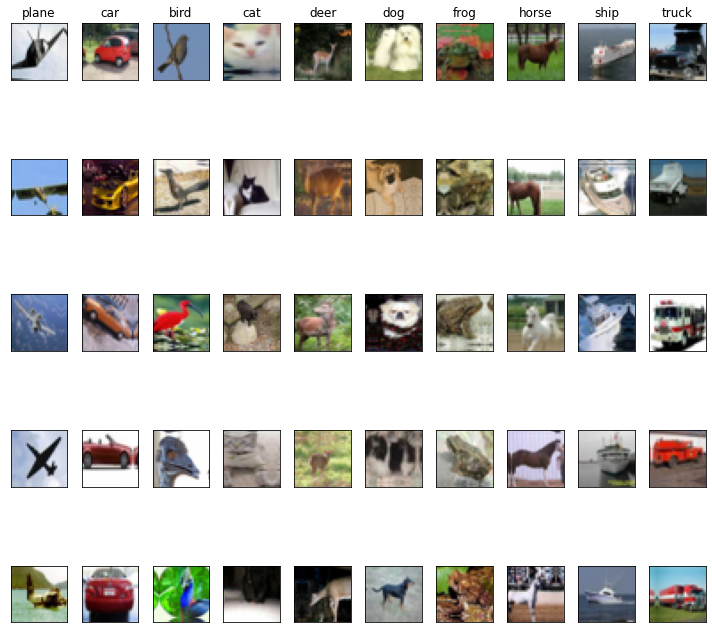

In [ ]:
dataiter = iter(train_loader)
images = {c: [] for c in classes}
while sum([len([x for x in images[c]]) for c in images]) != len(classes) * 5:
    img, label = dataiter.next()
    for i in range(len(img)):
        if len(images[classes[label[i]]]) != 5:
            images[classes[label[i]]] += [img[i]]

fig, axes = plt.subplots(nrows=5, ncols=len(classes), figsize=(9, 4.5), subplot_kw={'xticks': [], 'yticks': []})
fig.subplots_adjust(hspace=0.3, wspace=0.05)
for i in range(len(classes)):
    for j in range(5):
        img = torchvision.utils.make_grid(images[classes[i]][j])
        npimg = img.numpy().transpose(1, 2, 0)
        npimg = npimg * np.array((0.2023, 0.1994, 0.2010)) + np.array((0.4914, 0.4822, 0.4465))
        axes[j][i].imshow(npimg.clip(0, 1))
        axes[0][i].set_title(f"{classes[i]}")
plt.tight_layout()
plt.show()


## Model

Define your model here from scratch (You are not allowed to use the existing models in pytorch)

**NOTICE:** The model that you will have defined outputs a vector containing 10 numbers (for each class). Define a "feature space" that is a vector of size *N* (where *N > 10*) right before the last layer (You can then have a last layer like `nn.Linear(N, 10)`). See the image below to get a better understanding. We will use this later (we want to access the feature space of a sample when the sample is given to the model). The model tries to learn a representation of the samples in this feature space and we will see how good it could do this in later sections.

![Feature Space In Neural Network](https://i.postimg.cc/28Qjcn9D/feature-space-vis.png)

- **Hint I**: Our goal is to get accuracy above *90%* on testset. Our suggestion is to implement ResNet (ResNet18 could be a viable choice)
  - You can learn the network's structure and implementation online (Youtube, ...) and then implmenet it yourself and make changes to enhance it's performance on our task **(YOU SHOULD NOT COPY THE CODE!!! OTHERWISE, YOU'LL BE PENALIZED!!!)**

- **Hint II**: When defining your model, pay attension to the **NOTICE** part in the above. It's also better to read the "Exploring the feature space" section beforehand.  

In [ ]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(nn.Module) :
    def __init__(self, in_channels, num_classes, N):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(),
                                        nn.Linear(512, N))
        self.fc = nn.Linear(N, num_classes)
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        out = self.fc(out)
        return out





## Train

### Model instantiation

Create an instance of your model and move it to `device`

In [ ]:
# dataiter = iter(train_loader)
# images, labels = dataiter.next()
# print(images.shape)
# net = ResNet18(3, 10, 10)
# net = torchvision.models.resnet18()
N = 20
net = ResNet9(3, 10, N)
net.to(device)

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

### Criterion & Optimizater

Define `criterion` and `optimizer` (Or `scheduler`)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr = 0.001) # fine tuned the lr

### Train loop

Train your model 

Tasks:
- [ ] Things that are needed to be printed in each epoch:
  - Number of epoch
  - Train loss
  - Train accuracy
  - Validation loss
  - Validation accuracy
- [ ] save train/validation loss and accuracy (of each epoch) in an array for later usage

In [ ]:
epochs = 30
history = []

for e in range(epochs): 
  
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0
  running_total = 0.0
  val_running_total = 0.0
  
  for idx, (inputs, labels) in enumerate(train_loader):
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = net(inputs) 
    loss = criterion(outputs, labels) 
    
    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 
    
    _, preds = torch.max(outputs, 1) 
    running_total += labels.size(0)
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data) 

  else:
    with torch.no_grad(): 
      for idx, (val_inputs, val_labels) in enumerate(valid_loader):
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
        val_outputs = net(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        val_running_total += val_labels.size(0)
        _, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data)
      
    train_loss = running_loss/len(train_loader) 
    train_acc = running_corrects.item()/ running_total
    val_loss = val_running_loss/len(valid_loader)
    val_acc = val_running_corrects.item()/ val_running_total
    history += [(train_loss, train_acc, val_loss, val_acc)]
    print(f"epoch: {e+1} train loss: {train_loss:.4f} train acc: {train_acc:.2f} valid loss: {val_loss:.4f} valid acc: {val_acc:.2f}")

epoch: 1 train loss: 1.3697 train acc: 0.51 valid loss: 0.9361 valid acc: 0.62
epoch: 2 train loss: 0.8337 train acc: 0.71 valid loss: 0.6550 valid acc: 0.73
epoch: 3 train loss: 0.6230 train acc: 0.78 valid loss: 0.5559 valid acc: 0.76
epoch: 4 train loss: 0.5140 train acc: 0.82 valid loss: 0.4545 valid acc: 0.79
epoch: 5 train loss: 0.4385 train acc: 0.85 valid loss: 0.4147 valid acc: 0.80
epoch: 6 train loss: 0.3872 train acc: 0.87 valid loss: 0.3752 valid acc: 0.82
epoch: 7 train loss: 0.3385 train acc: 0.88 valid loss: 0.3765 valid acc: 0.81
epoch: 8 train loss: 0.3071 train acc: 0.89 valid loss: 0.3434 valid acc: 0.82
epoch: 9 train loss: 0.2804 train acc: 0.90 valid loss: 0.3324 valid acc: 0.83
epoch: 10 train loss: 0.2504 train acc: 0.91 valid loss: 0.3118 valid acc: 0.83
epoch: 11 train loss: 0.2361 train acc: 0.92 valid loss: 0.3080 valid acc: 0.84
epoch: 12 train loss: 0.2100 train acc: 0.93 valid loss: 0.3006 valid acc: 0.84
epoch: 13 train loss: 0.1915 train acc: 0.93 vali

### Visualize Loss and Accuracy plot

Using the arrays that you have (from task 2 in the above section), visualize two plots: Accuracy plot (train and validation together) and Loss plot (train and validation together)

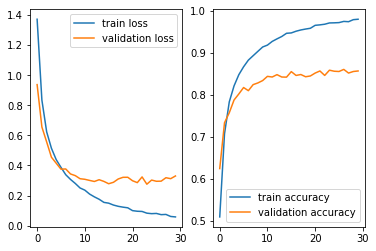

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].plot([d[0] for d in history], label='train loss')
axes[0].plot([d[2] for d in history], label='validation loss')
axes[0].legend()
axes[1].plot([d[1] for d in history], label='train accuracy')
axes[1].plot([d[3] for d in history], label='validation accuracy')
axes[1].legend()
# plt.tight_layout()
plt.show()

## Evaluation

Test your trained model (using the Test Dataloader that you have). Our goal is to reach an accuracy above `90%`

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'{correct / total}')

0.9148571428571428


## Visualize incorrectly predicted samples from testset

Visualize *24* random images from testset that are incorrectly predicted by the model

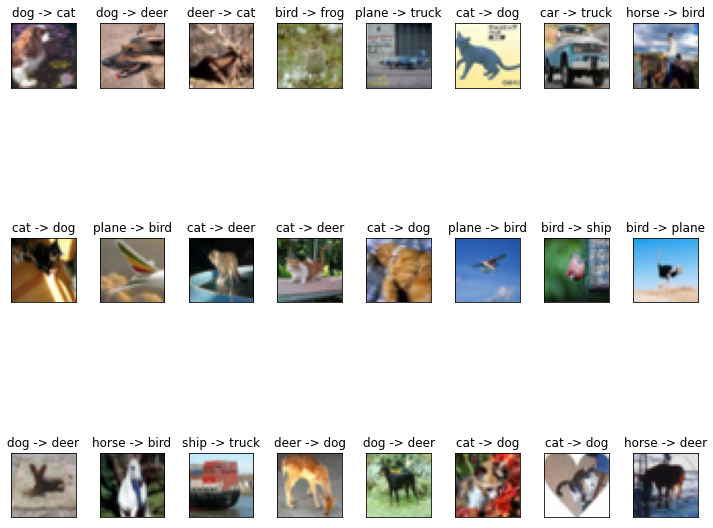

In [ ]:
incorrects = []
with torch.no_grad():
  for data in test_loader:
    images, labels = data[0].to(device), data[1].to(device)
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)
    for i in range(len(predicted)):
      if predicted[i] != labels[i]:
        incorrects.append((images[i], labels[i], predicted[i]))
np.random.shuffle(incorrects)
incorrects = incorrects[:24]
fig, axes = plt.subplots(nrows=3, ncols=8, figsize=(10, 10), subplot_kw={'xticks': [], 'yticks': []})
fig.subplots_adjust(hspace=0.3, wspace=0.05)
for i in range(3):
    for j in range(8):
        img = torchvision.utils.make_grid(incorrects[i * 8 + j][0])
        npimg = img.cpu().numpy().transpose(1, 2, 0)
        npimg = npimg * np.array((0.2023, 0.1994, 0.2010)) + np.array((0.4914, 0.4822, 0.4465))
        axes[i][j].imshow(npimg.clip(0, 1))
        axes[i][j].set_title(f"{classes[incorrects[i * 8 + j][1]]} -> {classes[incorrects[i * 8 + j][2]]}")
plt.tight_layout()
plt.show()

## Exploring the feature space

### Calculate the feature space for all training samples

You have trained and evaluated your model. Now, for each sample in the trainset, calculate it's "feature space" discussed in the model section. The result of this section should be a tensor of size `(50000, N)` saved in a variable (for later usage)

- **Hint 1:** define a tensor with dimension `(50000, N)` where *50000* is the size of the trainset and *N* is the dimension of the feature space

- **Hint 2:** Pay attension to the `shuffle` attribute of your train dataloader (If needed)

In [ ]:
def get_feature(net, inputs):
  out = net.conv1(inputs)
  out = net.conv2(out)
  out = net.res1(out) + out
  out = net.conv3(out)
  out = net.conv4(out)
  out = net.res2(out) + out
  out = net.classifier(out)
  return out.data

features = torch.zeros(50000, N)
train_images = []
features_classes = torch.zeros(50000)
i = 0
with torch.no_grad():
    for data in train_loader:
        images, labels = data[0].to(device), data[1].to(device)      
        train_images += images
        j = 0
        for d in get_feature(net, images):
          features[i] = d.cpu()
          features_classes[i] = labels[j].cpu()
          i += 1
          j += 1


### K Nearest Neighbor in feature space

You already have calculated the feature spaces for trainset ($S$) in the previous section

1. Get 5 random samples from testset which are correctly predicted by the model. 
2. for each sample, calculate it's "feature space" ($X$)
3. for each sample, calculate it's *5* nearest neighbors in "feature space" in the trainset (by comparing $X$ to each row in $S$) and visualize them

**Note:** Your visualization should be something like the below picture

**Hint:** For finding the nearest neighbors in the feature space you can use `torch.linalg.norm` and `torch.topk`

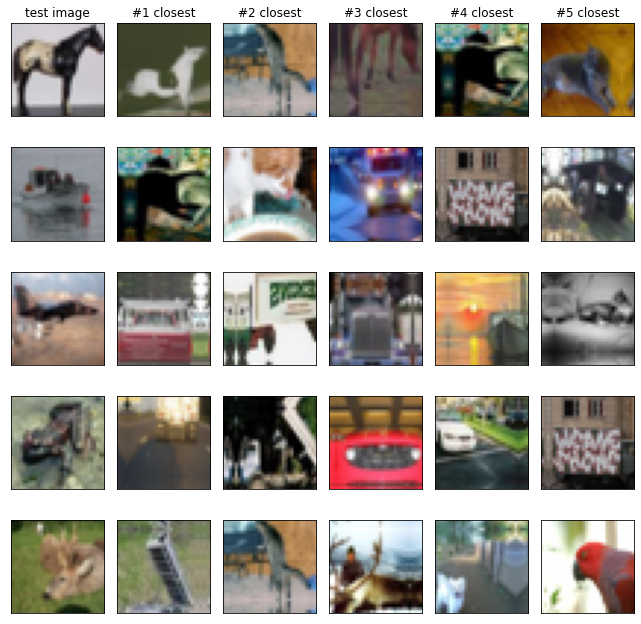

In [ ]:
def K_closest(net, features, img, k=5):
  b = torch.zeros(1, 3, 32, 32).to(device)
  b[0] = img
  f = get_feature(net, b)
  diff = torch.abs(features - f.cpu())
  norms = torch.linalg.norm(diff, dim=1)
  return torch.topk(norms, k, largest=False)[1]
  

corrects = []
with torch.no_grad():
  for data in test_loader:
    images, labels = data[0].to(device), data[1].to(device)
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)
    for i in range(len(predicted)):
      if predicted[i] == labels[i]:
        corrects.append((images[i], labels[i]))

np.random.shuffle(corrects)
rng = corrects[:5]
fig, axes = plt.subplots(nrows=5, ncols=6, figsize=(9, 9), subplot_kw={'xticks': [], 'yticks': []})
fig.subplots_adjust(hspace=0.3, wspace=0.05)
for i in range(5):
    img = torchvision.utils.make_grid(corrects[i][0])
    npimg = img.cpu().numpy().transpose(1, 2, 0)
    npimg = npimg * np.array((0.2023, 0.1994, 0.2010)) + np.array((0.4914, 0.4822, 0.4465))
    axes[i][0].imshow(npimg.clip(0, 1))
    axes[0][0].set_title(f"test image")
    idx = K_closest(net, features, img)
    for j in range(5):
        img = torchvision.utils.make_grid(train_images[idx[j]])
        npimg = img.cpu().numpy().transpose(1, 2, 0)
        npimg = npimg * np.array((0.2023, 0.1994, 0.2010)) + np.array((0.4914, 0.4822, 0.4465))
        axes[i][j+1].imshow(npimg.clip(0, 1))
        axes[0][j+1].set_title(f"#{j+1} closest")
plt.tight_layout()
plt.show()


### TSNE 

1. Sample $M$ ($2000$ would be enought) random samples from the trainset feature space (calculated in the above sections) 
2. Now you a vector of size `(M, N)` where $N$ is the dimension of the feature space
3. Using TSNE reduce $N$ to $2$ (Now you have a vector of size `(M, 2)`)
4. Print the shape of the output

**Hint:** You can use `sklearn.manifold.TSNE`

In [ ]:
M = 2000
perm = torch.randperm(50000)
idx = perm[:M]
samples = features[idx]
labels = features_classes[idx]
vec = sklearn.manifold.TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(samples)
print(vec.shape)

(2000, 2)


Visualize the points in a 2D plane (Set color of each point based on it's class)

**Notice:** Your visualization should be something like the below image

**Hint:** Use `plt.scatter(x, y, c=labels)`

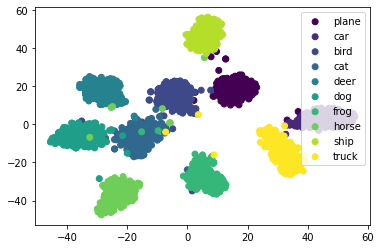

In [ ]:
cmap = plt.cm.viridis
norm = plt.Normalize(min(labels), max(labels))
for i in range(len(classes)):
  mask = labels == i
  plt.scatter(vec[mask, 0], vec[mask, 1], c=cmap(norm(labels[mask])), label=f"{classes[i]}")

plt.legend()
plt.show()

# CIFAR10 Colorization

In this part of the assignment, we want to do an image colorization task using PyTorch on CIFAR10 dataset. We want to train a model that colors  a black-and-white image.

## Import Libraries

Import needed libraries

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import sklearn.manifold

## Custom Dataset

Define a custom dataset class by extensing `torch.utils.data.Dataset`

**Notice:** your dataset should output two things: black-and-white image and the RGB image

**Hint:** You don't have to reinvent the wheel. Your class should just be a wrapper for CIFAR10 dataset

In [ ]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, train, transform):
        self._set = torchvision.datasets.CIFAR10(root='./data', train=train, download=True, transform=transform)

    def __len__(self):
        return len(self._set)

    def __getitem__(self, item):
        img, label = self._set[item]
        transform = transforms.Grayscale()
        return transform(img), img


## Transforms & Dataset & Dataloader

**Notice:** Use your defined custom dataset class for defining the datasets

In [ ]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) 
])
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])
batch_size = 400

train_set = CustomDataset(True, transform_train)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
test_set = CustomDataset(True, transform)
valid_size = int(0.3 * len(test_set))
test_size = len(test_set) - valid_size
test_set, valid_set = torch.utils.data.random_split(test_set, (test_size, valid_size))
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Dataset Visualization

Visualize your dataset (black-and-white image along with the RGB image) by sampling from your trainset

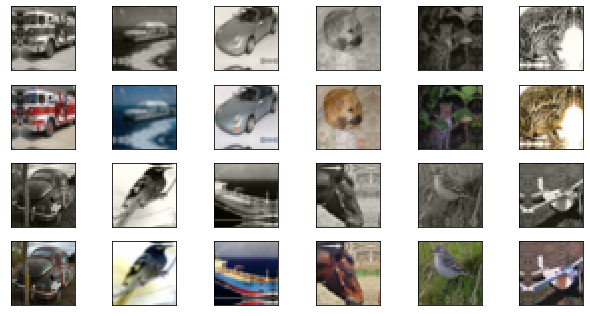

In [ ]:
dataiter = iter(train_loader)
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(9, 4.5), subplot_kw={'xticks': [], 'yticks': []})
fig.subplots_adjust(hspace=0.3, wspace=0.05)
for i in range(2):
    for j in range(6):
        gray, rgb = dataiter.next()
        img = torchvision.utils.make_grid(gray[j])
        npimg = img.numpy().transpose(1, 2, 0)
        npimg = npimg * np.array((0.2023, 0.1994, 0.2010)) + np.array((0.4914, 0.4822, 0.4465))
        axes[2 * i][j].imshow(npimg.clip(0, 1))
        img = torchvision.utils.make_grid(rgb[j])
        npimg = img.numpy().transpose(1, 2, 0)
        npimg = npimg * np.array((0.2023, 0.1994, 0.2010)) + np.array((0.4914, 0.4822, 0.4465))
        axes[2 * i + 1][j].imshow(npimg.clip(0, 1))
plt.tight_layout()
plt.show()

## Model

Define your model here (Input: black-and-white image, Output: RGB image)

**Hint:** You can implement an autoencoder that does the colorization task for you. UNet could be a viable option 

In [ ]:
class DownBlock(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.layers = nn.Sequential(
            nn.MaxPool2d(2),
            nn.Conv2d(in_features, out_features, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_features),
            nn.ReLU(),
            nn.Conv2d(out_features, out_features, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_features),
            nn.ReLU(),
        )
        
    def forward(self, x):
        return self.layers(x)


class UpBlock(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_features, in_features // 2, kernel_size=2, stride=2)
        self.conv = nn.Sequential(
            nn.Conv2d(in_features, out_features, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_features),
            nn.ReLU(),
            nn.Conv2d(out_features, out_features, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_features),
            nn.ReLU(),
        )

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels = 1, out_channels = 3):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.d1 = DownBlock(64, 128)
        self.d2 = DownBlock(128, 256)
        self.d3 = DownBlock(256, 512)
        self.d4 = DownBlock(512, 1024)
        self.u1 = UpBlock(1024, 512)
        self.u2 = UpBlock(512, 256)
        self.u3 = UpBlock(256, 128)
        self.u4 = UpBlock(128, 64)
        self.conv2 = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        x1 = self.conv(x)
        x2 = self.d1(x1)
        x3 = self.d2(x2)
        x4 = self.d3(x3)
        x5 = self.d4(x4)
        x = self.u1(x5, x4)
        x = self.u2(x, x3)
        x = self.u3(x, x2)
        x = self.u4(x, x1)
        return self.conv2(x)
        

## Train

Train your model

Tasks:
- [ ] Things that are needed to be printed in each epoch:
  - Number of epoch
  - Train loss
  - Validation loss
- [ ] save train/validation loss (of each epoch) in an array for later usage

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net = UNet().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr = 0.001) # fine tuned the lr

In [ ]:
epochs = 50
history = []

for e in range(epochs): 
  
  running_loss = 0.0
  val_running_loss = 0.0
  
  for idx, (inputs, labels) in enumerate(train_loader):
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = net(inputs) 
    loss = criterion(outputs, labels) 
    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 
    running_loss += loss.item()

  else:
    with torch.no_grad(): 
      for idx, (val_inputs, val_labels) in enumerate(valid_loader):
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
        val_outputs = net(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        val_running_loss += val_loss.item()
        
      
    train_loss = running_loss/len(train_loader) 
    val_loss = val_running_loss/len(valid_loader)
    history += [(train_loss, val_loss)]
    print(f"epoch: {e+1} train loss: {train_loss:.4f} valid loss: {val_loss:.4f}")

epoch: 1 train loss: 0.1747 valid loss: 0.1356
epoch: 2 train loss: 0.1306 valid loss: 0.1302
epoch: 3 train loss: 0.1279 valid loss: 0.1288
epoch: 4 train loss: 0.1260 valid loss: 0.1257
epoch: 5 train loss: 0.1256 valid loss: 0.1249
epoch: 6 train loss: 0.1239 valid loss: 0.1222
epoch: 7 train loss: 0.1220 valid loss: 0.1223
epoch: 8 train loss: 0.1215 valid loss: 0.1212
epoch: 9 train loss: 0.1204 valid loss: 0.1198
epoch: 10 train loss: 0.1204 valid loss: 0.1211
epoch: 11 train loss: 0.1190 valid loss: 0.1176
epoch: 12 train loss: 0.1189 valid loss: 0.1180
epoch: 13 train loss: 0.1178 valid loss: 0.1161
epoch: 14 train loss: 0.1166 valid loss: 0.1184
epoch: 15 train loss: 0.1158 valid loss: 0.1152
epoch: 16 train loss: 0.1153 valid loss: 0.1139
epoch: 17 train loss: 0.1148 valid loss: 0.1135
epoch: 18 train loss: 0.1134 valid loss: 0.1118
epoch: 19 train loss: 0.1127 valid loss: 0.1106
epoch: 20 train loss: 0.1120 valid loss: 0.1115
epoch: 21 train loss: 0.1117 valid loss: 0.1111
e

### Visualize Loss plot

Using the arrays that you have (from task 2 in the above section), visualize the loss plot (train and validation together)

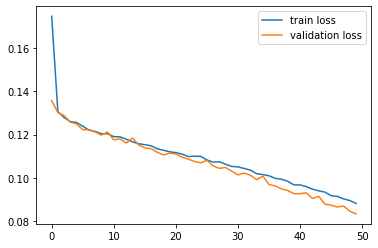

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=1)
axes.plot([d[0] for d in history], label='train loss')
axes.plot([d[1] for d in history], label='validation loss')
axes.legend()
# plt.tight_layout()
plt.show()

## Evaluation

1. Sample 36 random samples from testset (your own dataset class)
2. Give each of the 36 samples to your trained model and get the outputs
3. Visualize `input` (black-and-white image), `output` (output of the model with the given black-and-white input image) and `ground truth` (the actual RGB image)



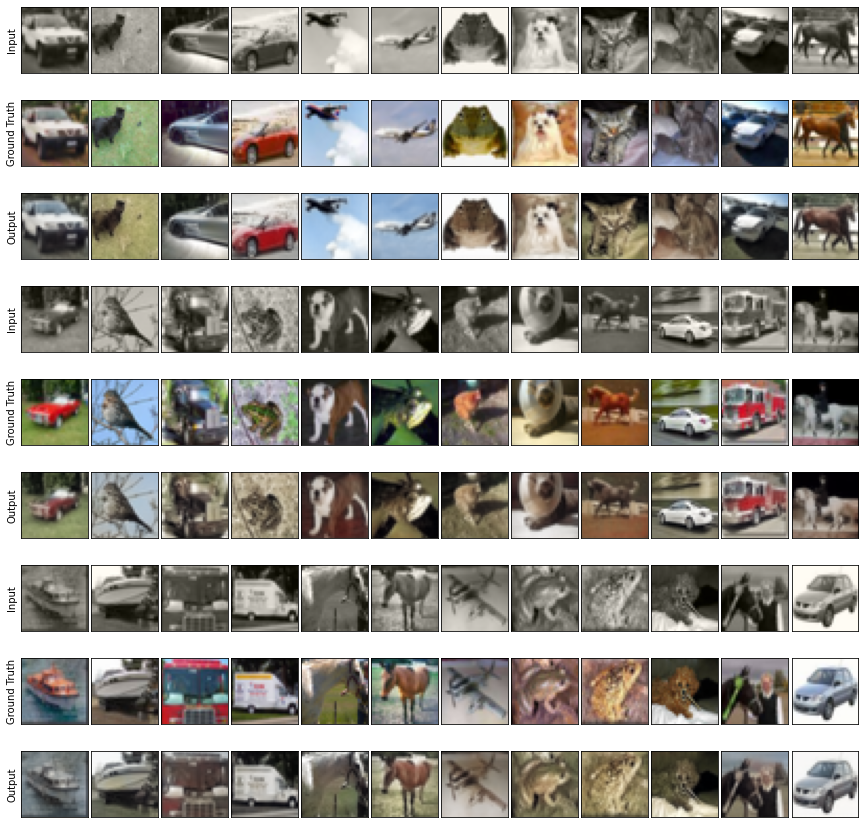

In [ ]:
I = []
T = []
O = []
with torch.no_grad():
  for data in test_loader:
    images, targets = data[0].to(device), data[1].to(device)
    outputs = net(images)
    I += images
    T += targets
    O += outputs
idx = np.array(list(range(len(I))))
np.random.shuffle(idx)
fig, axes = plt.subplots(nrows=9, ncols=12, figsize=(15, 15), subplot_kw={'xticks': [], 'yticks': []})
fig.subplots_adjust(hspace=0.3, wspace=0.05)
for i in range(3):
    for j in range(12):
        gray = I[idx[i * 12 + j]]
        truth = T[idx[i * 12 + j]]
        output = O[idx[i * 12 + j]]
        img = torchvision.utils.make_grid(gray)
        npimg = img.cpu().numpy().transpose(1, 2, 0)
        npimg = npimg * np.array((0.2023, 0.1994, 0.2010)) + np.array((0.4914, 0.4822, 0.4465))
        axes[3 * i][j].imshow(npimg.clip(0, 1))
        axes[3 * i][0].set_ylabel("Input")
        img = torchvision.utils.make_grid(truth)
        npimg = img.cpu().numpy().transpose(1, 2, 0)
        npimg = npimg * np.array((0.2023, 0.1994, 0.2010)) + np.array((0.4914, 0.4822, 0.4465))
        axes[3 * i + 1][j].imshow(npimg.clip(0, 1))
        axes[3 * i + 1][0].set_ylabel("Ground Truth")
        img = torchvision.utils.make_grid(output)
        npimg = img.cpu().numpy().transpose(1, 2, 0)
        npimg = npimg * np.array((0.2023, 0.1994, 0.2010)) + np.array((0.4914, 0.4822, 0.4465))
        axes[3 * i + 2][j].imshow(npimg.clip(0, 1))
        axes[3 * i + 2][0].set_ylabel("Output")
# plt.tight_layout()
plt.show()